In [ ]:
import random

%matplotlib inline
import networkx as nx


# 第 6 章

目次：

1. 分割
2. モジュラリティ
3. ザカリー空手クラブ
4. ガーバン-ニューマン クラスタリング・アルゴリズム



## 1. 分割

グラフの**分割**とは，そのノードを互いに重なっていないグループに分離することである．次のグラフを見てみよう．


In [ ]:
G = nx.Graph()
nx.add_cycle(G, [0, 1, 2, 3])
nx.add_cycle(G, [4, 5, 6, 7])
G.add_edge(0, 7)

nx.draw(G, with_labels=True)

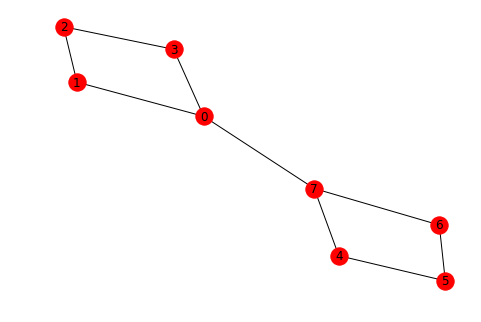


以下は，これらのノードの分割の一例である．


In [3]:
partition = [
    {1, 2, 3},
    {4, 5, 6},
    {0, 7},
]


グラフ内のすべてのノードが，分割内のセットの 1 つに含まれる．形式的には，分割は，すべてのノードがちょうど 1 つのセットに含まれるようなセットのリストである． NetworkX は，分割の有効性を確かめることができる．


In [4]:
nx.community.is_partition(G, partition)

True


コミュニティ検出アルゴリズムを開発するとき，*分割マップ*をよく利用する．これは，ノード名から分割のインデックスにマッピングする辞書である．これは，2 つのノードがある分割で同じクラスターにあるかどうかをすばやく比較するのに役立つ．


In [5]:
partition_map = {}
for idx, cluster_nodes in enumerate(partition):
    for node in cluster_nodes:
        partition_map[node] = idx

partition_map

{1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 0: 2, 7: 2}


この辞書では，キーはノード名であり，2 つのノードが同じ分割にある場合，それらの値は同じになるはずである．


In [6]:
partition_map[0] == partition_map[7]

True


分割のクラスターによって色分けされたノードを使用してグラフを描画することで，可視化することができる．


In [ ]:
node_colors = [partition_map[n] for n in G.nodes]
        
nx.draw(G, node_color=node_colors, with_labels=True)

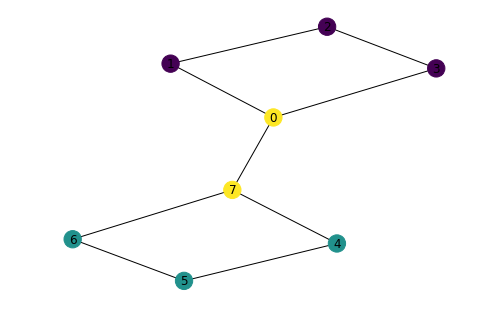


2 つの単純な分割：

1. すべてのノードを含む 1 つのセットしかない分割
2. それぞれが 1 つのノードを含む N 個のセットを持つ分割

がある．したがって，有効な分割は 1 ～ N 個の間にある．

前述した分割を変更し，後続のセルを実行して自由に実験せよ．



## 2. モジュラリティ

大まかに言うと，ネットワークのコミュニティの検出は，ノードのグループ間を適切に分離する分割を見つけることである．グラフの適切な分割を見つける前に，評価方法，つまり，分割がどの程度良好かを測定する方法が必要である．モジュラリティは，そのような目的関数の 1 つである．

グラフ分割のモジュラリティは，クラスタ内のエッジの数をランダムなベースラインと比較する．モジュラリティスコアが高いことは，グループ内のエッジの割合が高くなるため，グループ間のエッジが少なくなり，グループの分離が向上することを意味する．

テキストで説明されているように，重み付けされた無向ネットワークの場合，

\begin{equation}
    Q_w=\frac{1}{W}\sum_C \left(W_C-\frac{s_C^2}{4W}\right),
\end{equation}

が成り立つ．ただし，
- $W$ はネットワークのリンクの重みの合計
- $W_C$ はクラスタ $C$ の内部リンクの重みの合計
- $s_C$ は $C$ のノードの強度の合計

である．エッジの数 $L$ が総次数の半分であるのと同じ理由で，重みの合計 $W$ は総強度の半分である．この式は少し複雑に見えるかもしれないが，下に示したように，合計を計算するコードを書くのは簡単である．


In [8]:
def modularity(G, partition):
    W = sum(G.edges[v, w].get('weight', 1) for v, w in G.edges)
    summation = 0
    for cluster_nodes in partition:
        s_c = sum(G.degree(n, weight='weight') for n in cluster_nodes)
        # サブグラフを使って内部リンクだけを数える
　　　　 C = G.subgraph(cluster_nodes)
        W_c = sum(C.edges[v, w].get('weight', 1) for v, w in C.edges)
        summation += W_c - s_c ** 2 / (4 * W)
    
    return summation / W

In [9]:
modularity(G, partition)

0.2222222222222222


これを，モジュラリティが高いと思われる分割と比べたい．


In [10]:
partition_2 = [
    {0, 1, 2, 3},
    {4, 5, 6, 7},
]
modularity(G, partition_2)

0.3888888888888889


### NetworkX の関数

NetworkX は，先述のものよりも効率的なモジュラリティ関数を提供する．


In [11]:
nx.community.quality.modularity(G, partition_2)

0.38888888888888884


## 3. ザカリーの空手クラブ



コミュニティ検出アルゴリズムを作成したり，テストしたりする場合，ベンチマークとなるネットワーク，つまり既存の「自然な」コミュニティ構造を持つグラフを利用するのが有効である．おそらく最も有名なベンチマークグラフは，ザカリーの空手クラブ（Zachary's Karate Club）だろう．これには34 個のノードがあり，空手クラブのメンバーを表す．彼らの交流は，研究者により 3 年間にわたって追跡された．このグラフのリンクは，クラブ活動外でも交流する個人の結びつきであり，社会的つながりの代用となっている．

調査の過程で，師範の Hi 氏 (ノード 0) と部長 (ノード 33) との間の対立により，クラブは Hi 氏と部長が率いる別々のグループに分裂した．この時，グループの各メンバーが分裂後に誰を支持したかがわかったため，実証的なコミュニティ・ラベルが提供されている．Hi 氏をフォローしたメンバーが一方のコミュニティを形成し，部長を支持したメンバーが他方のコミュニティを形成している．

このグラフでは，分裂後のグループ構成は主に社会的つながりによって決定されたと想定する．つまり，同じ友人グループのメンバーは，分裂後も同じクラブの一員になりたいと考えるだろう．したがって，分裂後のグループ構成を高精度で予測するための優れたコミュニティ検出アルゴリズムが期待される．

ザカリーの空手クラブは非常に有名なベンチマーク・グラフであるため，NetworkX でも独自の関数を備えている．


In [ ]:
K = nx.karate_club_graph()
nx.draw(K, with_labels=True)

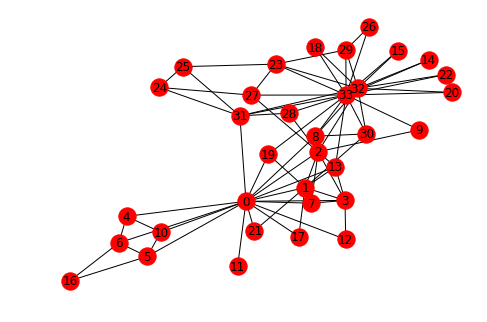


グラフの各ノードには，関連付けられた*属性*の辞書オブジェクトがあり，この辞書にはノードに関する任意のデータが保持される．`nodes` オブジェクトにノード名を指定することで，単一ノードの属性を取得できる．

このグラフの各ノードには `'club'` 属性があり，分裂後にメンバーがHi氏，または部長のどちらを支持したかを示している．


In [13]:
K.nodes[0]

{'club': 'Mr. Hi'}

In [14]:
K.nodes[9]

{'club': 'Officer'}


`'club'` 属性で各ノードに色分けることで，これらのラベルを視覚化できる．


In [ ]:
K = nx.karate_club_graph()
club_color = {
    'Mr. Hi': 'orange',
    'Officer': 'lightblue',
}
node_colors = [club_color[K.nodes[n]['club']] for n in K.nodes]
nx.draw(K, node_color=node_colors, with_labels=True)

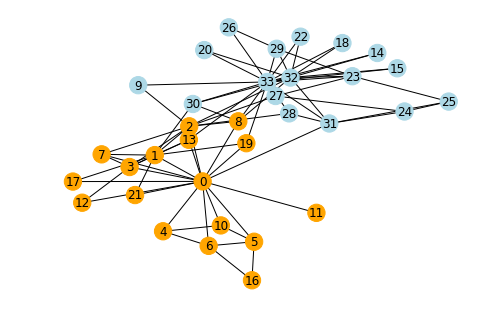


コミュニティ内のリンクとは対照的に，コミュニティ間のリンクが比較的少ないという点で，この分離はいいように見える．これらのラベルに基づいてグラフを分割し，そのモジュラリティを測定したい．

これを行うには，まず，ノードの `'club'` 属性の値ごとに 1 つずつ，2 つのセットの辞書を作成し，ノードを対応するセットに割り当てる．


In [16]:
groups = {
    'Mr. Hi': set(),
    'Officer': set(),
}

for n in K.nodes:
    club = K.nodes[n]['club']
    groups[club].add(n)
    
groups

{'Mr. Hi': {0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 16, 17, 19, 21},
 'Officer': {9,
  14,
  15,
  18,
  20,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33}}


辞書の`.values()`メソッドを使用して，分割内のそれぞれのセットのリストを取得できる．


In [17]:
empirical_partition = list(groups.values())
empirical_partition

[{0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 16, 17, 19, 21},
 {9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33}]

In [18]:
nx.community.is_partition(K, empirical_partition)

True

この分割は確かに有効なので，そのモジュラリティを得ることができる．

In [19]:
nx.community.quality.modularity(K, empirical_partition)

0.39143756676224206


予想した通り，これは比較的高いモジュラリティである．

### ランダム分割との比較

比較のために，このネットワークのランダム分割とそのモジュラリティを確認したい．この場合，モジュラリティはゼロに近いと予想される．

まず，全ノード数の半分である 17 ノードのサンプルを生成し，それらを 1 つのコミュニティに割り当てる．次に，2 番目のコミュニティには，最初のコミュニティに含まれない全てのノードが含まれる．これを簡潔に行うために集合演算を使用したい．


In [20]:
random_nodes = random.sample(K.nodes, 17)
random_partition = [set(random_nodes),
                    set(K.nodes) - set(random_nodes)]
random_partition

since Python 3.9 and will be removed in a subsequent version.
  random_nodes = random.sample(K.nodes, 17)


[{0, 1, 2, 3, 6, 8, 11, 12, 16, 17, 22, 23, 25, 26, 28, 32, 33},
 {4, 5, 7, 9, 10, 13, 14, 15, 18, 19, 20, 21, 24, 27, 29, 30, 31}]


この分割を可視化すると，ランダムな割り当てから予想されるように，コミュニティがかなり不自然になっていることがわかる．


In [ ]:
random_node_colors = ['orange' if n in random_nodes else 'lightblue' for n in K.nodes]
nx.draw(K, node_color=random_node_colors)

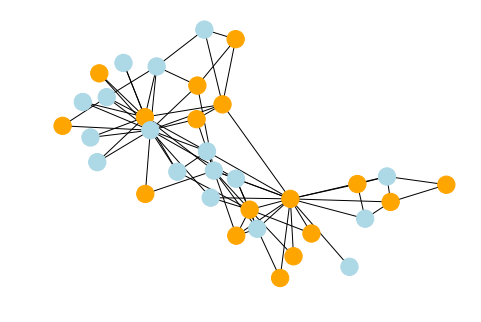


最後に，この分割のモジュラリティをテストする．


In [22]:
nx.community.quality.modularity(K, random_partition)

-0.1327936133130938


これはランダムなプロセスであるため，モジュラリティが完全にゼロになることはないが，かなり近いはずである．ランダム分割とそのモジュラリティをテストするプロセスを繰り返せば，その平均値ゼロを中心に変動すると分かる．



# 4. ガーバン-ニューマンクラスタリング

ここでは，ガーバン−ニューマンクラスタリングアルゴリズムが実装される． NetworkX は私たちに代わって面倒な媒介中心性の計算を行ってくれるので，タスクのコード部分は比較的簡単である．私たちの労力は，ほとんど中間結果の解釈と説明に費やすことができる．

テキストからガーバン−ニューマンクラスタリングアルゴリズムを思い出してみよう．

1. 分割のシーケンスを作成する
2. すべてのリンクの媒介中心性を計算する
3. 媒介中心性が最大のリンクを削除し，連結成分を使用して分割を作る
4. 結果のグラフのリンクの媒介中心性を再計算する
5. リンクがなくなるまで，3以降を繰り返す
6. シーケンス内の各分割モジュラリティが最も高いものを選ぶ

このプロセスの間，クラスターが分割されるにつれて，グラフ内の連結成分の数は単調に増加する．一度に 1 つのリンクを削除するため，連結成分の数は，シーケンスのステップ間で最大 1 しか増加しない．それは，1つのエッジが 2 つより多くのノード，すなわちコンポーネントを接続することができないためである．

グラフの分割の結果が背後のコミュニティ構造に近似することを期待する．私たちは真実のコミュニティラベルを知っており，アルゴリズムから得られた結果を比較できるため，ここでは空手クラブのグラフを使用する．


In [ ]:
G = nx.karate_club_graph()
nx.draw(G)

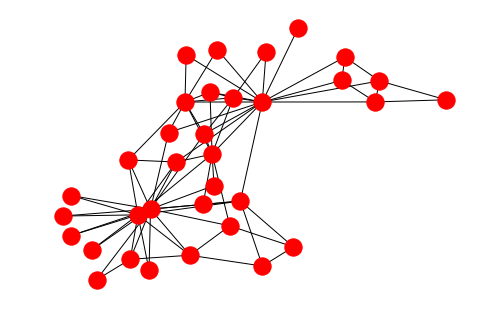


## 4.1 分割シーケンスの作成

### A.　すべてのリンクの媒介中心性を計算する

NetworkX がここでは面倒な作業を行うので，出力された内容を理解するだけでよい．


In [24]:
nx.edge_betweenness_centrality(G)

{(0, 1): 0.025252525252525245,
 (0, 2): 0.0777876807288572,
 (0, 3): 0.02049910873440285,
 (0, 4): 0.0522875816993464,
 (0, 5): 0.07813428401663694,
 (0, 6): 0.07813428401663695,
 (0, 7): 0.0228206434088787,
 (0, 8): 0.07423959482783014,
 (0, 10): 0.0522875816993464,
 (0, 11): 0.058823529411764705,
 (0, 12): 0.04652406417112298,
 (0, 13): 0.04237189825425121,
 (0, 17): 0.04012392835922248,
 (0, 19): 0.045936960642843,
 (0, 21): 0.040123928359222474,
 (0, 31): 0.1272599949070537,
 (1, 2): 0.023232323232323233,
 (1, 3): 0.0077243018419489,
 (1, 7): 0.007422969187675069,
 (1, 13): 0.01240556828792123,
 (1, 17): 0.01869960105254222,
 (1, 19): 0.014633732280791102,
 (1, 21): 0.01869960105254222,
 (1, 30): 0.032280791104320514,
 (2, 3): 0.022430184194890075,
 (2, 7): 0.025214328155504617,
 (2, 8): 0.009175791528732704,
 (2, 9): 0.030803836686189627,
 (2, 13): 0.007630931160342923,
 (2, 27): 0.04119203236850296,
 (2, 28): 0.02278244631185807,
 (2, 32): 0.06898678663384543,
 (3, 7): 0.00336558


得られた辞書はエッジのタプルがキーであり，関連する値はそのエッジの媒介中心性が値となる．グラフ内のすべてのエッジの媒介性を計算するアルゴリズムは，単一のエッジに対して計算するのとほぼ同じコストがかかるため，すべてのエッジの計算された値を持つこの辞書を利用する．

すべてのエッジについて計算すると，単一のエッジに関連付けられた媒介性を簡単に取得できる．例えば，ノード 0 と 1 の間のエッジの媒介性を取得するには，次のようにする．


In [25]:
my_edge_betweenness = nx.edge_betweenness_centrality(G)
my_edge_betweenness[0, 1]

0.025252525252525245


辞書にも `.get` メソッドがある．これは次のステップで使用する．


In [26]:
my_edge_betweenness.get((0, 1))

0.025252525252525245


### B.　媒介中心性が最大のリンクを削除する

各エッジの媒介中心性の値の辞書があれば，Python の組み込み `max` 関数を使用して，この辞書内の最大値を持つキーを得ることができる．グラフのすべてのエッジに対して辞書にはキーがあるため，次の 2 つの式は同等だが，わかりやすさの視点からすると，2 番目の式の方がより明確である．

`my_edge_betweenness` という名前を使用しているのは，これが NetworkX の関数ではなく，私たちが名付けた辞書であることを明確にするためである．


In [27]:
max(my_edge_betweenness, key=my_edge_betweenness.get)

(0, 31)

In [28]:
max(G.edges(), key=my_edge_betweenness.get)

(0, 31)


したがってこのステップで削除すべきエッジは上（下？）記となる．


In [29]:
my_edge_betweenness = nx.edge_betweenness_centrality(G)
most_valuable_edge = max(G.edges(), key=my_edge_betweenness.get)
G.remove_edge(*most_valuable_edge)

上のセルの最後のステートメントの「スプラット」演算子 `G.remove_edge(*most_valuable_edge)` は，タプルを展開し，関数の引数にするものである．例えば，`most_valuable_edge` が `(0, 31)` であると，

    G.remove_edge(*most_valuable_edge)
は
    
    G.remove_edge(most_valuable_edge[0], most_valuable_edge[1])
または

    G.remove_edge(0, 31)

と同等である．


### B.（続き）　…そして，連結成分を使用して分割を作る

`nx.connected_components()` 関数は私たちが求めるものをほぼ正確に提供するため，これはとても簡単である．


In [30]:
nx.connected_components(G)

<generator object connected_components at 0x000002D90DB60270>


ただし，リストでリクエストすることを忘れないように．


In [31]:
list(nx.connected_components(G))

[{0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33}]

覚えておこう：分割とは，グラフのそれぞれのノードがこれらのセットのちょうど１つに含まれるセットのリストである．エッジを 1 つしか削除していないので，連結成分はまだ1つである．必要ならば，1つ以上の連結成分ができるまで，前の2つのセルを数回実行してみよう．

連結成分が推定されたコミュニティのラベルに正確に対応するというこの特徴は，ガーバン-ニューマンアルゴリズム特有のものであることに注意してほしい．他のクラスタリング・アルゴリズムでは，異なる分割の生成方法を用いることができる．


### C.　得られたグラフのリンクの媒介中心性を再計算する

### D.　リンクがなくなるまでB以降を繰り返す

これは，このプロセスをエッジごとに $L$ 回繰り返すループが必要であり，生成された分割を追跡する必要があることを意味している．簡単なことで．上記のいくつかのエッジを削除したので，新しく作った空手クラブのグラフから始めよう．


In [32]:
G = nx.karate_club_graph()
partition_sequence = []
for _ in range(G.number_of_edges()):
    my_edge_betweenness = nx.edge_betweenness_centrality(G)
    most_valuable_edge = max(G.edges(), key=my_edge_betweenness.get)
    G.remove_edge(*most_valuable_edge)
    my_partition = list(nx.connected_components(G))
    partition_sequence.append(my_partition)

この `for` ループの慣習的な構造に注目してほしい．ループ変数の名前に `_` を使うことで，ループ変数で何かを行うことを期待しているわけではなく，あるタスクを特定の回数だけ実行したいだけであることを読者に伝えることができる．ここで `while` ループを使いたくなるかもしれないが，`while` ループでミスをすると，頭痛の種である無限ループになる可能性があり，そうなるととんでもないことになる．

もしこれが正しくできていれば，プロセスの各ステップ，つまりグラフの各辺ごとに分割ができるはずである．

In [33]:
len(partition_sequence), nx.karate_club_graph().number_of_edges()

(78, 78)


連結グラフから始めたので，エッジを 1 つ削除してもおそらくグラフは切断されないため，最初の分割にはおそらく 1 つのコミュニティしかない．


In [34]:
len(partition_sequence[0])

1


そして，最後の分割は，それぞれのノードが独自のコミュニティ内にある単純なものとなるはずである．


In [35]:
len(partition_sequence[-1]), nx.karate_club_graph().number_of_nodes()

(34, 34)


## 4.2 シーケンス内の各分割のモジュラリティを評価する

これで分割のシーケンスと，各々の分割のモジュラリティを計算する関数ができた．リスト内包表記を使う絶好の場面である！


In [36]:
G = nx.karate_club_graph()
modularity_sequence = [modularity(G, p) for p in partition_sequence]
modularity_sequence

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.34766027623170476,
 0.34766027623170476,
 0.34766027623170476,
 0.3423192968647515,
 0.3423192968647515,
 0.3423192968647515,
 0.3423192968647515,
 0.3580611307884035,
 0.3580611307884035,
 0.3580611307884035,
 0.3580611307884035,
 0.3580611307884035,
 0.3580611307884035,
 0.38497217068645645,
 0.37578006409175246,
 0.37578006409175246,
 0.3594760218136842,
 0.3594760218136842,
 0.3470699574595679,
 0.3470699574595679,
 0.333249002080171,
 0.333249002080171,
 0.3134405277262421,
 0.3134405277262421,
 0.3122598901819681,
 0.3122598901819681,
 0.3036862127771219,
 0.3036862127771219,
 0.2942973332583722,
 0.2942973332583722,
 0.2827158411573995,
 0.2827158411573995,
 0.27116245947414774,
 0.27116245947414774,
 0.2544648713479881,
 0.2544648713479881,
 0.2397537527407657,
 0.2397537527407657,
 0.22689792170311643,
 0.22299057363992422,
 0.22299057363992422,
 0.22299057363992422,
 0.20056783043796034,
 0.20056783043796034,
 0.1


このシーケンスには，アルゴリズムの各ステップでの分割のモジュラリティルがある．このシーケンスの最初のいくつかの要素は，コミュニティ（あるいは連結成分）が 1 つしかない間は事実上ゼロであり，複数のコミュニティが存在すると飛躍的におおきくなる． pyplot を使用すると，この関係を視覚化できる．


Text(0.5, 0, 'Algorithm step')

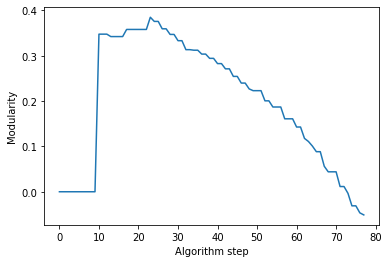

In [37]:
import matplotlib.pyplot as plt
plt.plot(modularity_sequence)
plt.ylabel('Modularity')
plt.xlabel('Algorithm step')


### モジュラリティが最も高い分割を得る



視覚的には，モジュラリティのシーケンスにピークが見られ，その値はモジュラリティを最大化する分割であり，アルゴリズムの出力でもある． `max` 関数を使用して，モジュラリティが最も高い分割を取得できる．理想的には，次のように記述したい．


In [38]:
best_partition = max(partition_sequence, key=nx.community.quality.modularity)

TypeError: modularity() missing 1 required positional argument: 'communities'

…しかし，エラーが表示される．キー関数は正確に 1 つの引数（評価されるシーケンスのアイテム）をとらなければならないが，モジュラリティ関数は 2 つの引数（グラフとその分割）をとることを思い出してほしい．これを解決するには，キーとして使う引数 1 つの関数を作ればいい．

In [39]:
def my_modularity(partition):
    return nx.community.quality.modularity(G, partition)
best_partition = max(partition_sequence, key=my_modularity)

上級の Python ユーザーなら，`zip` 関数を使って以前に生成された分割とモジュラリティの並びを整列させるという別の解決策を見出すことができるだろうが，この解決策はより明確である．

結局のところ，最良の分割は何だろうか？

In [40]:
best_partition

[{0, 1, 3, 7, 11, 12, 13, 17, 19, 21},
 {2, 24, 25, 27, 28, 31},
 {4, 5, 6, 10, 16},
 {8, 14, 15, 18, 20, 22, 23, 26, 29, 30, 32, 33},
 {9}]


面白い！モジュラリティが最も高い空手クラブの分割には 5 つのコンポーネントがある！このチュートリアルの冒頭で書いた分割マップを作るコード用いて，それらを可視化したい．


In [41]:
def create_partition_map(partition):
    partition_map = {}
    for idx, cluster_nodes in enumerate(partition):
        for node in cluster_nodes:
            partition_map[node] = idx
    return partition_map

In [ ]:
best_partition_map = create_partition_map(best_partition)

node_colors = [best_partition_map[n] for n in G.nodes()]
nx.draw(G, with_labels=True, node_color=node_colors)

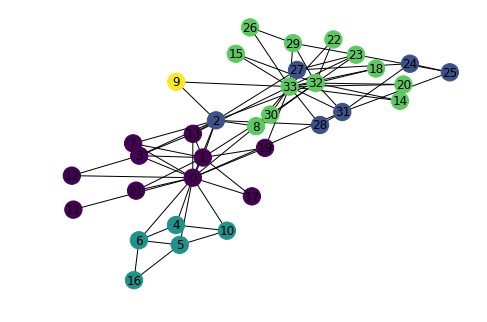


このコミュニティの５分割は，いったいどのようなものだろうか？


In [43]:
nx.community.quality.modularity(G, best_partition)

0.3849721706864564

3 節で評価した，グラウンド・トゥルースの分割よりも値が高いのは良い兆候だが，分割後のコミュニティ・メンバーシップを予測するという特定の問題に対しては，5 つのグループにクラスタリングすることは意味がない．

### コミュニティ数を指定しで最良の分割を得る

ガーバン-ニューマンアルゴリズムの長所の1つは，必要とするクラスタ数を決められることである．この場合，空手クラブは 2 つのグループに分かれることが分かっているので，2 つの連結成分を持つシーケンスで分割を得よう．

In [44]:
for partition in partition_sequence:
    if len(partition) == 2:
        two_cluster_partition = partition
        break

two_cluster_partition

[{0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21},
 {2, 8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33}]

In [ ]:
two_cluster_partition_map = create_partition_map(two_cluster_partition)

node_colors = [two_cluster_partition_map[n] for n in G.nodes()]
nx.draw(G, with_labels=True, node_color=node_colors)

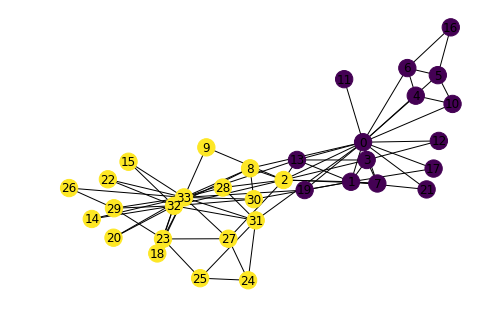


この分割でどうだろう？このモジュラリティを得ることができる．


In [46]:
nx.community.quality.modularity(G, two_cluster_partition)

0.3476602762317048


グラウンド・トゥルースの分割に匹敵する良さだ．これらを並べて比較しよう．


In [ ]:
import matplotlib.pyplot as plt

pos = nx.layout.spring_layout(G)
fig = plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
two_cluster_partition_map = create_partition_map(two_cluster_partition)
node_colors = [two_cluster_partition_map[n] for n in G.nodes()]
nx.draw(G, with_labels=True, node_color=node_colors, pos=pos)
plt.title('Predicted communities')

plt.subplot(1, 2, 2)
node_colors = [G.nodes[n]['club'] == 'Officer' for n in G.nodes()]
nx.draw(G, with_labels=True, node_color=node_colors, pos=pos)
plt.title('Actual communities')

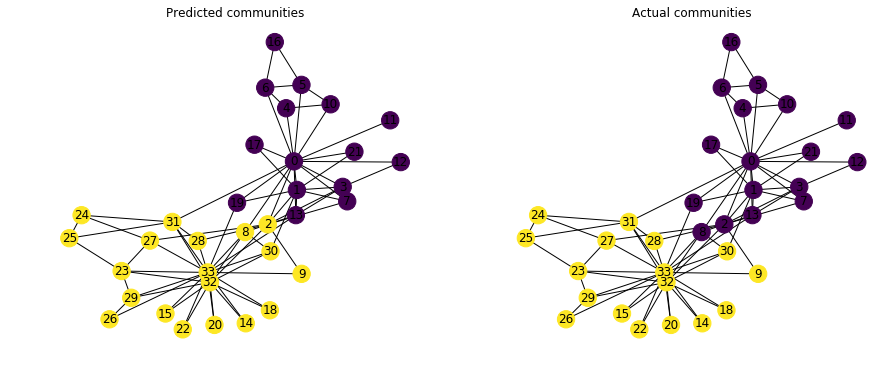

予測されたコミュニティ・ラベルはかなり正確で，見た目にはどちらのグループにも属しそうなノードがいくつかあるだけである．ザカリーの元の論文では，このような予測ミスのノードの 1 つについて，現実的な考察まで説明している．それによると，弟子 8 は Hi 氏から黒帯を受け取る寸前であったため，友人が離れたにもかかわらず，Hi氏のグループに残りたかったと考えらえるようだ．

In [48]:
G.nodes[8]

{'club': 'Mr. Hi'}

#### 補足

勘のいい読者なら，私たちが生成した分割のシーケンスの中に 2 クラスタ分割がいくつかあるかもしれないことに気づくだろう．以下のことが真であると断言する：

1. ノード数 1 から N の整数ごとに，その数のクラスタを持つパーティションが存在する
2. シーケンスにある同じクラスタ数の分割はすべて同じである

これらを証明することは読者への練習問題として残されるが，これらが真であることの結果として，ガーバン-ニューマンアルゴリズムの最適化された実装は，各クラスタ数に対して 1 つのパーティションしか保存しない．NetworkXの 実装はこのように動作し，1以上のコミュニティ数に対して1つのパーティションしか与えない．


## NetworkX の関数

`nx.community.girvan_newman(G)` はサイズが 1 より大きい分割を一つずつ生成する．ここで，最初のいくつかが私たちが生成したものと同じであることがわかる．


In [49]:
list(nx.community.girvan_newman(G))[:5]

[({0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21},
  {2, 8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33}),
 ({0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21},
  {2, 8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33},
  {9}),
 ({0, 1, 3, 7, 11, 12, 13, 17, 19, 21},
  {2, 8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33},
  {4, 5, 6, 10, 16},
  {9}),
 ({0, 1, 3, 7, 11, 12, 13, 17, 19, 21},
  {2, 24, 25, 27, 28, 31},
  {4, 5, 6, 10, 16},
  {8, 14, 15, 18, 20, 22, 23, 26, 29, 30, 32, 33},
  {9}),
 ({0, 1, 3, 7, 12, 13, 17, 19, 21},
  {2, 24, 25, 27, 28, 31},
  {4, 5, 6, 10, 16},
  {8, 14, 15, 18, 20, 22, 23, 26, 29, 30, 32, 33},
  {9},
  {11})]